In [1]:
import os
from pathlib import Path
import pickle
from collections import defaultdict
from itertools import product

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from tqdm.auto import tqdm

import torch
import torch.nn as nn

from deep_ei import topology_of, ei_of_layer, sensitivity_of_layer, vector_ei_of_layer

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
dtype = torch.float32
torch.set_default_dtype(dtype)
print(f"Using {device} device")

Using cuda device


In [3]:
def blueMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("Blues")
    return colormap(0.85 * pos / size + 0.15) # avoid using the lightest blue color -- it's not visible

## First generate the $EI_{parts}$ and sensitivity data

In [4]:
tiny_network = nn.Linear(2, 1, bias=False).to(device)
top = topology_of(tiny_network, input=torch.zeros(1, 2).to(device))

bins = 64
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -10.0, 10.0
stepSize = (ubound - lbound) / evalPoints

x = y = np.arange(lbound, ubound, stepSize)
X, Y = np.meshgrid(x, y)
rX,rY = np.ravel(X), np.ravel(Y)

eis = []
for i in tqdm(range(evalPoints * evalPoints)):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    ei = ei_of_layer(tiny_network, top, 
                     samples=10000, 
                     batch_size=500, 
                     in_range=(0, 1), 
                     in_bins=bins,
                     out_range=(0, 1), 
                     out_bins=bins,
                     activation=nn.Sigmoid(), 
                     device=device)
    eis.append(ei)
    
zs = np.array(eis)
eis = zs.reshape(X.shape)

sens = []
for i in tqdm(range(evalPoints * evalPoints)):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    sen = sensitivity_of_layer(tiny_network, top, 
                               samples=10000, 
                               batch_size=500,
                               in_range=(0, 1),
                               in_bins=bins,
                               out_range=(0, 1),
                               out_bins=bins,
                               activation=nn.Sigmoid(),
                               device=device)
    sens.append(sen)
    
zs = np.array(sens)
sens = zs.reshape(X.shape)

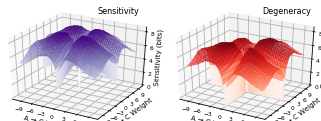

In [37]:
plt.figure(figsize=(5.5, 2.0))

ax = plt.subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(X, Y, sens, cmap=plt.cm.Purples, label="sensitivity")
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.tick_params(axis='both',which='major', labelsize=6, pad=-5)

ax.set_title("Sensitivity", fontsize=8, x=0.8, y=1.05)
ax.set_xlabel('A → C Weight', fontsize=7)
ax.set_ylabel('B → C Weight', fontsize=7)
ax.set_zlabel("Sensitivity (bits)", fontsize=7)
ax.xaxis.labelpad = -12
ax.yaxis.labelpad = -12
ax.zaxis.labelpad = -14
ax.set_zlim(0, 8.5)
ax.dist = 8
ax.text(0, 0, -8.0, "(a)", size=9, ha="center", weight="bold")

# if i == 0:
#     ax.text(0, 0, -5.4, ilabel['row2'][i], size=9, ha="center", weight="bold")
# elif i == 1:
#     ax.text(0, 0, -5.2, ilabel['row2'][i], size=9, ha="center", weight="bold")
# elif i == 2:
#     ax.text(0, 0, -7.3, ilabel['row2'][i], size=9, ha="center", weight="bold")
    
# plt.subplots_adjust(hspace=0.7, wspace=0.3)

ax = plt.subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(X, Y, sens-eis, cmap=plt.cm.Reds, label="degeneracy")
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.tick_params(axis='both',which='major', labelsize=6, pad=-5)

ax.set_title("Degeneracy", fontsize=8, x=0.8, y=1.05)
ax.set_xlabel('A → C Weight', fontsize=7)
ax.set_ylabel('B → C Weight', fontsize=7)
ax.set_zlabel("Degeneracy (bits)", fontsize=7)
ax.xaxis.labelpad = -12
ax.yaxis.labelpad = -12
ax.zaxis.labelpad = -14
ax.set_zlim(0, 8.5)
ax.dist = 8
ax.text(0, 0, -8.0, "(b)", size=9, ha="center", weight="bold")

plt.subplots_adjust(bottom=0.2)

plt.savefig('figures/sensitivity-degeneracy-toy-network.pdf', dpi=100)


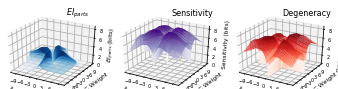

In [54]:
plt.figure(figsize=(5.5, 1.5))

ax = plt.subplot(1, 3, 1, projection='3d')
surf = ax.plot_surface(X, Y, eis, cmap=plt.cm.Blues, label="EI")
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.tick_params(axis='both',which='major', labelsize=5, pad=-5)

ax.set_title("$EI_{parts}$", fontsize=8, x=0.8, y=1.05)
ax.set_xlabel('A → C Weight', fontsize=6)
ax.set_ylabel('B → C Weight', fontsize=6)
ax.set_zlabel("$EI_{parts}$ (bits)", fontsize=6)
ax.xaxis.labelpad = -12
ax.yaxis.labelpad = -12
ax.zaxis.labelpad = -12
ax.set_zlim(0, 8.5)
ax.dist = 8
ax.text(0, 0, -12, "(a)", size=9, ha="center", weight="bold")

ax = plt.subplot(1, 3, 2, projection='3d')
surf = ax.plot_surface(X, Y, sens, cmap=plt.cm.Purples, label="sensitivity")
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.tick_params(axis='both',which='major', labelsize=5, pad=-5)


ax.set_title("Sensitivity", fontsize=8, x=0.8, y=1.05)
ax.set_xlabel('A → C Weight', fontsize=6)
ax.set_ylabel('B → C Weight', fontsize=6)
ax.set_zlabel("Sensitivity (bits)", fontsize=6)
ax.xaxis.labelpad = -12
ax.yaxis.labelpad = -12
ax.zaxis.labelpad = -12
ax.set_zlim(0, 8.5)
ax.dist = 8
ax.text(0, 0, -12, "(b)", size=9, ha="center", weight="bold")

# if i == 0:
#     ax.text(0, 0, -5.4, ilabel['row2'][i], size=9, ha="center", weight="bold")
# elif i == 1:
#     ax.text(0, 0, -5.2, ilabel['row2'][i], size=9, ha="center", weight="bold")
# elif i == 2:
#     ax.text(0, 0, -7.3, ilabel['row2'][i], size=9, ha="center", weight="bold")
    
# plt.subplots_adjust(hspace=0.7, wspace=0.3)

ax = plt.subplot(1, 3, 3, projection='3d')
surf = ax.plot_surface(X, Y, sens-eis, cmap=plt.cm.Reds, label="degeneracy")
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.tick_params(axis='both',which='major', labelsize=5, pad=-5)

ax.set_title("Degeneracy", fontsize=8, x=0.8, y=1.05)
ax.set_xlabel('A → C Weight', fontsize=6)
ax.set_ylabel('B → C Weight', fontsize=6)
ax.set_zlabel("Degeneracy (bits)", fontsize=6)
ax.xaxis.labelpad = -12
ax.yaxis.labelpad = -12
ax.zaxis.labelpad = -12
ax.set_zlim(0, 8.5)
ax.dist = 8
ax.text(0, 0, -12, "(c)", size=9, ha="center", weight="bold")

plt.subplots_adjust(bottom=0.3, wspace=0.3, left=0.1, right=0.9)

plt.savefig('figures/ei-sensitivity-degeneracy-toy-network.pdf', dpi=100)


In [8]:
ei_wholes = []
for i in tqdm(range(evalPoints * evalPoints)):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    ei = vector_ei_of_layer(tiny_network, top, 
                     samples=10000, 
                     batch_size=500, 
                     in_range=(0, 1), 
                     in_bins=bins,
                     out_range=(0, 1), 
                     out_bins=bins,
                     activation=nn.Sigmoid(), 
                     device=device)
    ei_wholes.append(ei)

In [9]:
zs = np.array(ei_wholes)
ei_wholes = zs.reshape(X.shape)

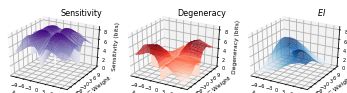

In [11]:
plt.figure(figsize=(5.5, 1.6))

ax = plt.subplot(1, 3, 1, projection='3d')
surf = ax.plot_surface(X, Y, sens, cmap=plt.cm.Purples, label="sensitivity")
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.tick_params(axis='both',which='major', labelsize=5, pad=-5)


ax.set_title("Sensitivity", fontsize=8, x=0.8, y=1.05)
ax.set_xlabel('A → C Weight', fontsize=6)
ax.set_ylabel('B → C Weight', fontsize=6)
ax.set_zlabel("Sensitivity (bits)", fontsize=6)
ax.xaxis.labelpad = -12
ax.yaxis.labelpad = -12
ax.zaxis.labelpad = -12
ax.set_zlim(0, 8.5)
ax.dist = 8
ax.text(0, 0, -12, "(a)", size=9, ha="center", weight="bold")

# if i == 0:
#     ax.text(0, 0, -5.4, ilabel['row2'][i], size=9, ha="center", weight="bold")
# elif i == 1:
#     ax.text(0, 0, -5.2, ilabel['row2'][i], size=9, ha="center", weight="bold")
# elif i == 2:
#     ax.text(0, 0, -7.3, ilabel['row2'][i], size=9, ha="center", weight="bold")
    
# plt.subplots_adjust(hspace=0.7, wspace=0.3)

ax = plt.subplot(1, 3, 2, projection='3d')
surf = ax.plot_surface(X, Y, sens - ei_wholes, cmap=plt.cm.Reds, label="degeneracy")
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.tick_params(axis='both',which='major', labelsize=5, pad=-5)

ax.set_title("Degeneracy", fontsize=8, x=0.8, y=1.05)
ax.set_xlabel('A → C Weight', fontsize=6)
ax.set_ylabel('B → C Weight', fontsize=6)
ax.set_zlabel("Degeneracy (bits)", fontsize=6)
ax.xaxis.labelpad = -12
ax.yaxis.labelpad = -12
ax.zaxis.labelpad = -12
ax.set_zlim(0, 8.5)
ax.dist = 8
ax.text(0, 0, -12, "(b)", size=9, ha="center", weight="bold")


ax = plt.subplot(1, 3, 3, projection='3d')
surf = ax.plot_surface(X, Y, ei_wholes, cmap=plt.cm.Blues, label="EI")
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(3.0))
ax.tick_params(axis='both',which='major', labelsize=5, pad=-5)

ax.set_title("$EI$", fontsize=8, x=0.8, y=1.05)
ax.set_xlabel('A → C Weight', fontsize=6)
ax.set_ylabel('B → C Weight', fontsize=6)
ax.set_zlabel("$EI$ (bits)", fontsize=6)
ax.xaxis.labelpad = -12
ax.yaxis.labelpad = -12
ax.zaxis.labelpad = -12
ax.set_zlim(0, 8.5)
ax.dist = 8
ax.text(0, 0, -12, "(c)", size=9, ha="center", weight="bold")


plt.subplots_adjust(bottom=0.3, wspace=0.3, left=0.08, right=0.92)

plt.savefig('figures/ei-sensitivity-degeneracy_whole-toy-network.pdf', dpi=100)
